In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import random
%matplotlib inline

In [2]:
words = open('../../data/names.txt','r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {char:i for i,char in enumerate(chars)}
stoi['.'] = 0 
itos = {i:char for char,i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
27


In [3]:
def build_dataset(words): 
    block_size = 3
    X, Y = [], []
    for w in words: 
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
        

In [4]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train , Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [60]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
            

In [73]:
n_embedding = 10 
block_size = 3
n_hidden = 100
g = torch.Generator().manual_seed(42)

C = torch.randn(vocab_size, n_embedding, generator = g)

layers = [
   Linear(n_embedding * block_size, n_hidden), Tanh(),
   Linear(n_hidden, n_hidden, bias= False), BatchNorm1d(n_hidden), Tanh(),
   Linear(n_hidden, n_hidden, bias= False), BatchNorm1d(n_hidden), Tanh(),
   Linear(n_hidden, n_hidden, bias= False), BatchNorm1d(n_hidden), Tanh(),
   Linear(n_hidden, n_hidden, bias= False), BatchNorm1d(n_hidden), Tanh(),
   Linear(n_hidden, vocab_size, bias= False), BatchNorm1d(vocab_size), 
 ]

l

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46924


In [74]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
ud = [] # Update to Data ratio

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 5000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
    #break
    

      0/  20000: 3.2838
   5000/  20000: 2.2280
  10000/  20000: 2.1154
  15000/  20000: 2.2668


## Activation Statistics

layer 1 (      Tanh): mean +0.07, std 0.77, saturated: 22.81%
layer 4 (      Tanh): mean -0.00, std 0.66, saturated: 7.19%
layer 7 (      Tanh): mean -0.01, std 0.68, saturated: 5.31%
layer 10 (      Tanh): mean -0.00, std 0.69, saturated: 4.56%
layer 13 (      Tanh): mean -0.01, std 0.70, saturated: 3.53%


Text(0.5, 1.0, 'Activation Distribution')

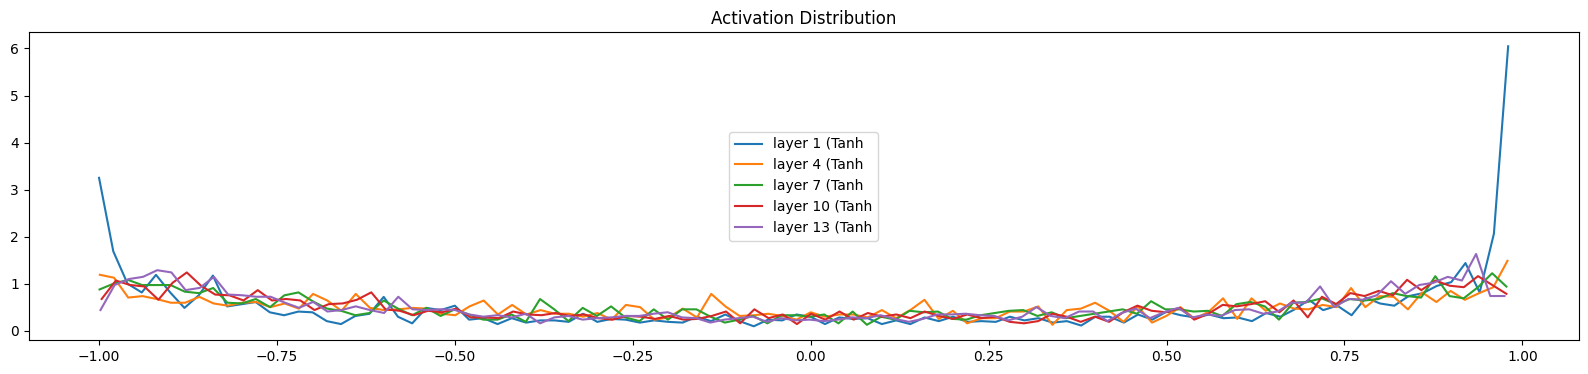

In [77]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
        
plt.legend(legends, loc = 'center');
plt.title('Activation Distribution')
        
        

## Gradient Distribution

layer 1 (      Tanh): mean +0.000000 std 3.146082e-03
layer 4 (      Tanh): mean -0.000000 std 2.421499e-03
layer 7 (      Tanh): mean +0.000000 std 2.329363e-03
layer 10 (      Tanh): mean +0.000000 std 2.266333e-03
layer 13 (      Tanh): mean +0.000000 std 2.282454e-03


Text(0.5, 1.0, 'Gradient Distribution')

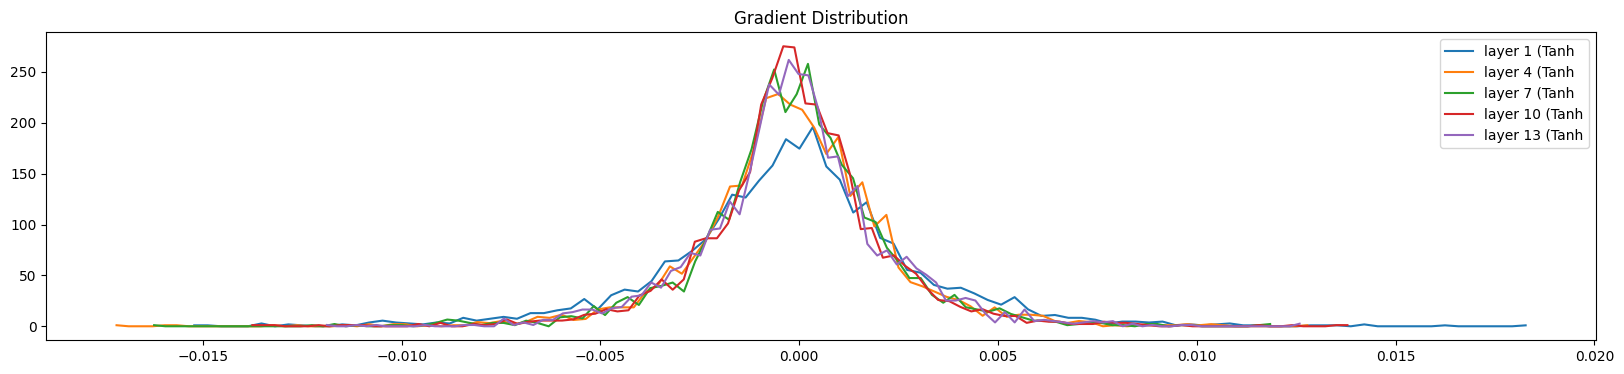

In [78]:
plt.figure(figsize = (20,4))
legends = []

for i, layer in enumerate(layers[:-1]): 
    if isinstance(layer, Tanh): 
        t = layer.out.grad
        print('layer %d (%10s): mean %+f std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
        
plt.legend(legends, loc = 'upper right');
plt.title('Gradient Distribution')

## Gradient to Weights Ratio

weights   (27, 10): mean -0.000030 std 7.779588e-03. grad:data ration 4.939270e-03
weights  (30, 100): mean -0.000130 std 8.704206e-03. grad:data ration 3.211115e-02
weights (100, 100): mean +0.000114 std 6.162958e-03. grad:data ration 4.256373e-02
weights (100, 100): mean -0.000022 std 5.590565e-03. grad:data ration 4.113206e-02
weights (100, 100): mean +0.000031 std 5.350967e-03. grad:data ration 4.092991e-02
weights (100, 100): mean +0.000022 std 5.005834e-03. grad:data ration 3.935448e-02
weights  (100, 27): mean -0.000097 std 9.368802e-03. grad:data ration 4.113488e-02


Text(0.5, 1.0, 'Weights Gradient Distrubtion')

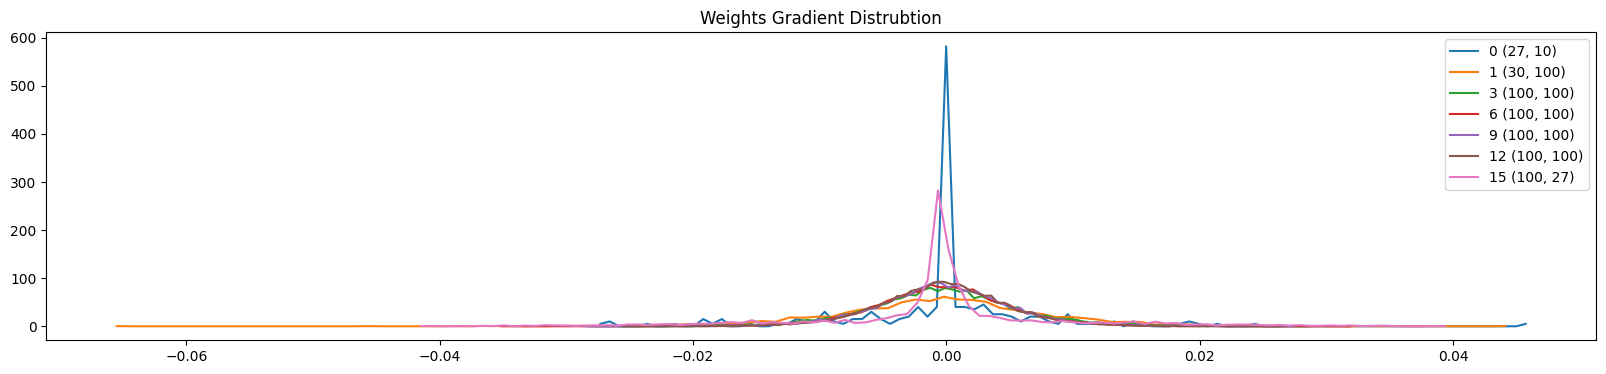

In [79]:
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim == 2: 
        print('weights %10s: mean %+f std %e. grad:data ration %e' % (tuple(p.shape), t.mean(), t.std(), (p.grad.abs().mean() / p.abs().mean()).item()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
        
plt.legend(legends, loc = 'upper right')
plt.title('Weights Gradient Distrubtion')

## Updates to Data Ratios

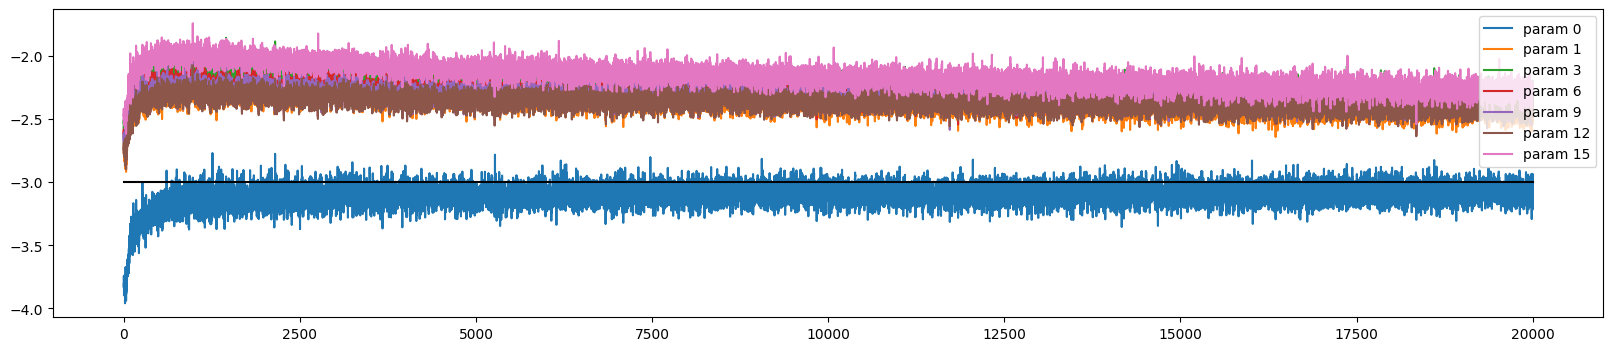

In [81]:
plt.figure(figsize=(20,4)) 
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2: 
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i )
        
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends, loc = 'upper right'); 
        

In [82]:
@torch.no_grad()

def split_loss(split): 
    x, y = {'train': (X_train, Y_train), 'val': (X_val, Y_val), 'test': (X_test, Y_test)}[split]
    
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers: 
        x = layer(x)
        
    loss = F.cross_entropy(x, y)
    print(f'{split} loss: {loss.item()}')
    
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train loss: 2.1010537147521973
val loss: 2.1200931072235107


In [86]:
g = torch.Generator().manual_seed(42)

for _ in range(20): 
    
    out = [] 
    context = [0] * block_size
    
    while True: 
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers: 
            x = layer(x)
        
        logits = x 
        probs = F.softmax(logits, dim = 1)
        
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0: 
            break
        
    print(''.join(itos[ix] for ix in out))

z.
.
terin.
.
mir.
emy.
luknell.
ker.
jezire.
dixo.
foc.
emir.
kj.
rri.
l.
k.
t.
re.
.
.
